### Блок практики

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('corrupted_processed_train.csv')
data.head()

,Unnamed: 0,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Platform_windows7,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN
0,0,0.552153,0.530936,0.587952,7.0,0,53447.0,1.0,1.0,1,...,False,False,True,False,False,False,False,True,False,False
1,1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,...,False,False,True,False,False,False,False,False,True,False
2,2,0.552153,0.530936,0.557522,7.0,0,53447.0,1.0,1.0,1,...,False,False,True,False,False,False,False,True,False,False
3,7,0.552153,0.530936,0.482759,7.0,0,53447.0,1.0,1.0,1,...,False,False,True,False,False,False,False,True,False,False
4,8,0.493169,0.530936,0.505721,7.0,0,53447.0,1.0,1.0,1,...,False,False,True,False,False,False,False,True,False,False


Разобьем выборку на тест и трейн

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='HasDetections')
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

# Создайте пайплайны для Logistic Regression и SVM
# Подсказка: используйте MinMaxScaler() и соответствующие модели

pipe_lr = Pipeline([
('LR_scaler',MinMaxScaler()),
('svm',LogisticRegression())
])

pipe_svm = Pipeline([
('SVM_scaler',MinMaxScaler()),
('SVM',LinearSVC())
])

Постройте ROC для обеих моделей, посчитайте AUC. Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$

In [15]:
# Обучите модели на трейне
# your code here
pipe_lr.fit(X_train,y_train)
pipe_svm.fit(X_train,y_train)

Pipeline(steps=[('SVM_scaler', MinMaxScaler()), ('SVM', LinearSVC())])

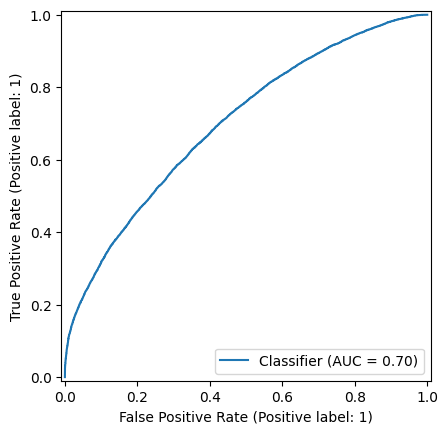

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_pred = pipe_lr.predict_proba(X_test)[:,1]
# Постройте ROC-кривую для LogReg
# your code here
RocCurveDisplay.from_predictions(y_test,y_pred)


In [28]:
# Преобразуйте выходы decision_function для SVM в вероятности
# Подсказка: используйте пропорциональное преобразование на основе min и max значений
decision_func_arr = pipe_svm.decision_function(X_test)
l = decision_func_arr.min()
r = decision_func_arr.max()
DFA_to_prob = MinMaxScaler().fit_transform(decision_func_arr.reshape(-1,1))

# your code here

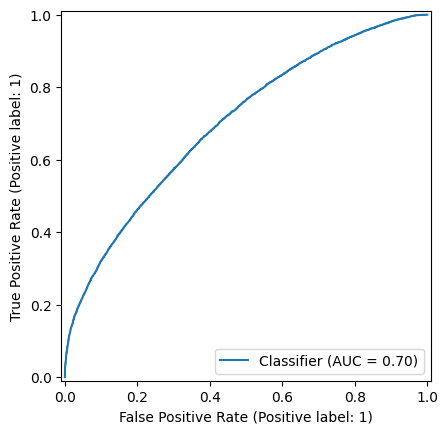

In [33]:
# Постройте ROC-кривую для SVM
# your code here
RocCurveDisplay.from_predictions(y_test,DFA_to_prob)

In [34]:
from sklearn.metrics import auc 
lr_fpr,lr_tpr,lr_thld = roc_curve(y_test,y_pred)
auc(lr_fpr,lr_tpr)
# Вычислите AUC для обеих моделей
# your code here

np.float64(0.699942139392826)

In [35]:
svm_fpr,svm_tpr,svm_thld = roc_curve(y_test,DFA_to_prob)
auc(svm_fpr,svm_tpr)

np.float64(0.7017240003215865)

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

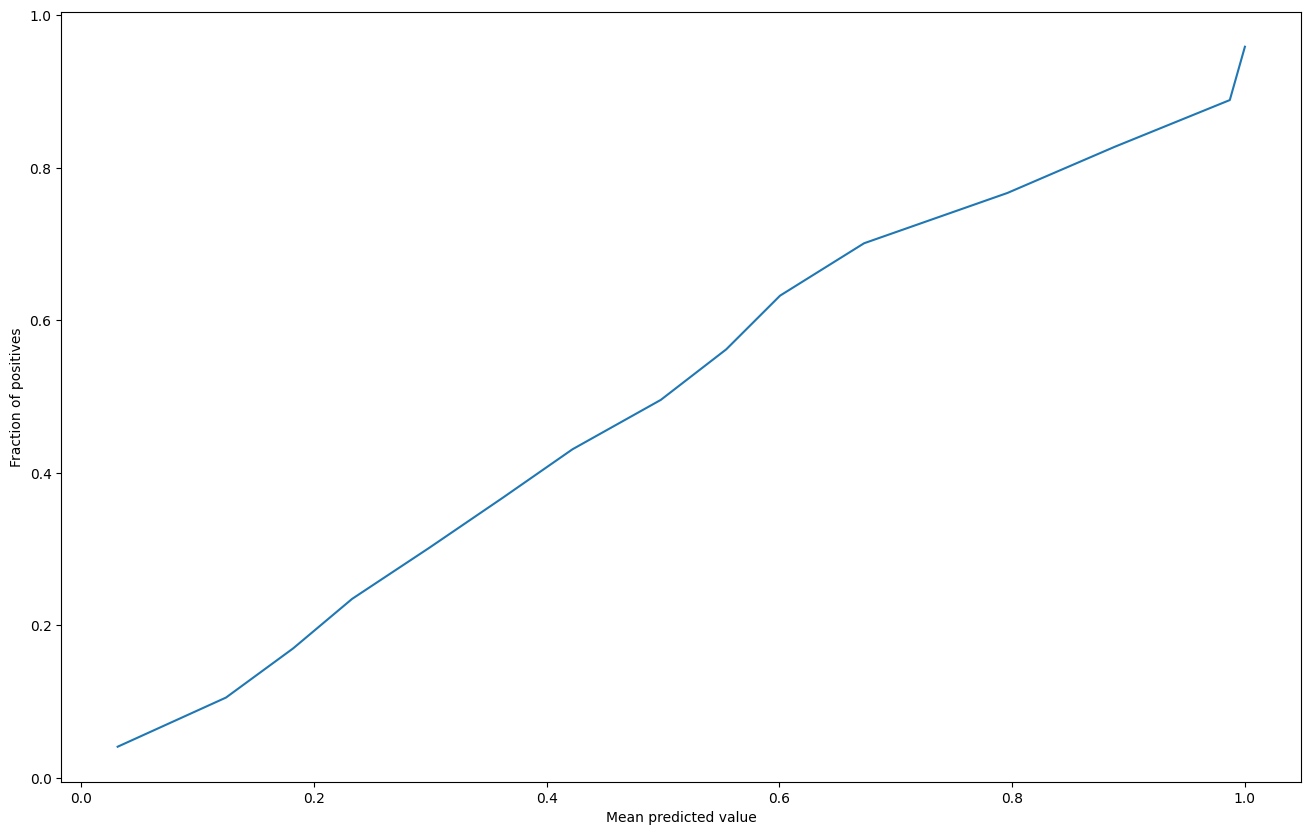

In [38]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Постройте калибровочную кривую для LogReg
# your code here
lr_prob_true,lr_prob_pred = calibration_curve(y_test,y_pred,n_bins=15)
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(lr_prob_true,lr_prob_pred)
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.show()

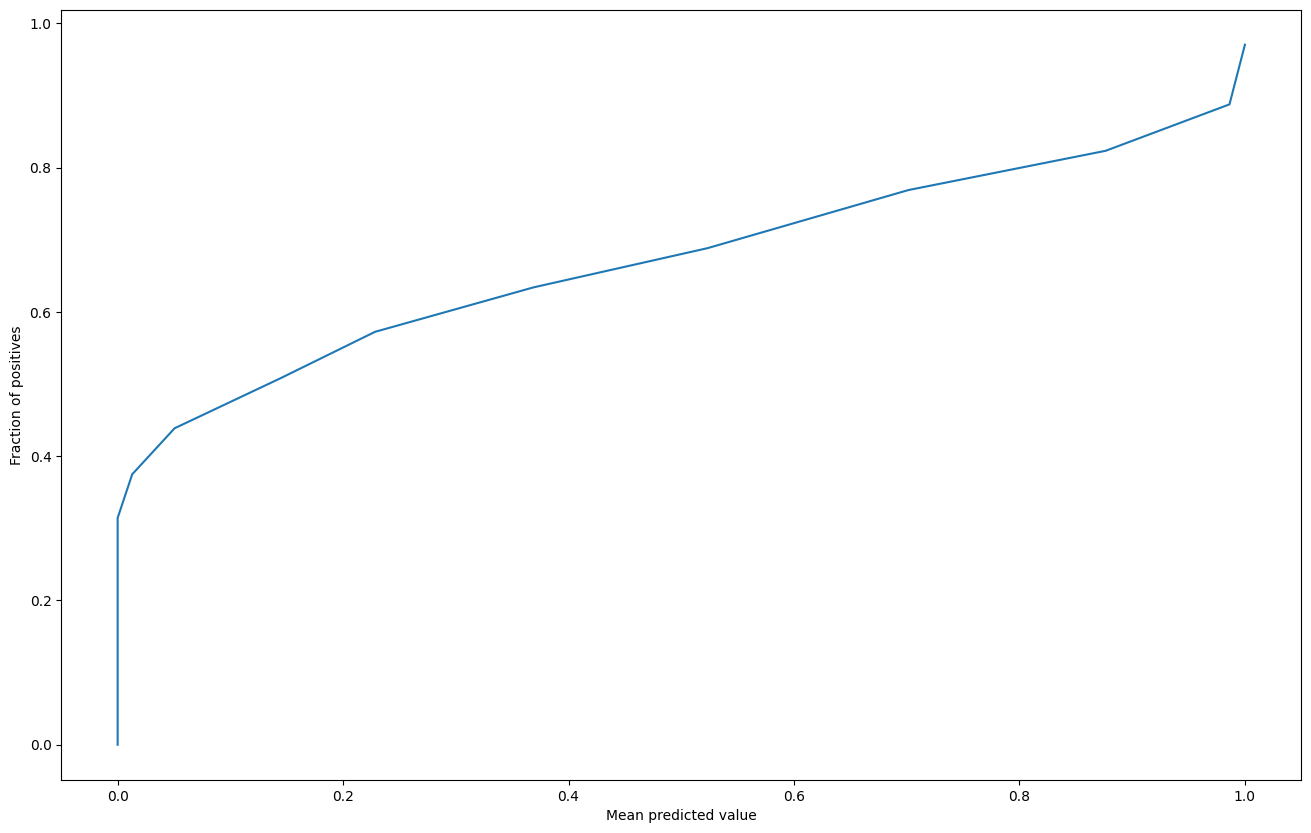

In [39]:
# Постройте калибровочную кривую для SVM
# your code here
svm_prob_true,svm_prob_pred = calibration_curve(y_test,DFA_to_prob,n_bins=15)
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(svm_prob_true,svm_prob_pred)
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.show()

Какая калибровочная кривая ближе к диагонали? Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [41]:
# Калибровка SVM с использованием Platt Scaling
# your code here
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

calibration = CalibratedClassifierCV(pipe_svm,cv=5)
calibration.fit(X_train,y_train)
calibrated_probs = calibration.predict_proba(X_test)[:,1]

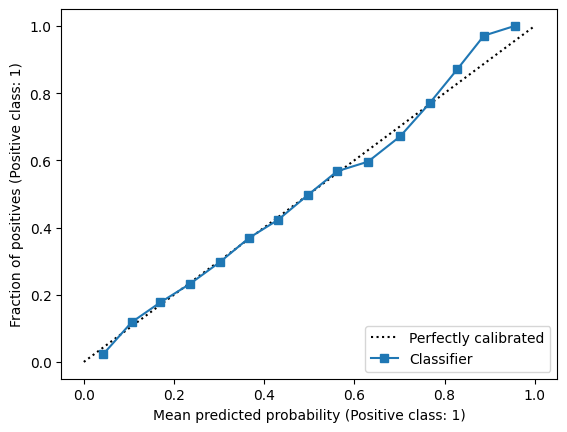

In [42]:
# Постройте новую калибровочную кривую для SVM после калибровки
# your code here
CalibrationDisplay.from_predictions(y_test,calibrated_probs,n_bins=15)